## Setup

In [85]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [87]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [88]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [89]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [90]:
%%R 
# the variable B23018 was selectd from the census table 
# for Aggregate Usual Hours Worked by Sex, which we found in censusreporter here:
# https://censusreporter.org/tables/B23018/

# Here are the various geographies with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        total_hour="B23018_001",
                        male_hour = "B23018_002",
                        female_hour="B23018_003"
                      ), 
                      year = 2023,
                      survey="acs5",
                      geometry=T   
)

nyc_census_data


Simple feature collection with 6981 features and 5 fields (with 9 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME    variable estimate
1  36005023502 Census Tract 235.02; Bronx County; New York  total_hour    70509
2  36005023502 Census Tract 235.02; Bronx County; New York   male_hour    32571
3  36005023502 Census Tract 235.02; Bronx County; New York female_hour    37938
4  36005013500    Census Tract 135; Bronx County; New York  total_hour    33429
5  36005013500    Census Tract 135; Bronx County; New York   male_hour    12188
6  36005013500    Census Tract 135; Bronx County; New York female_hour    21241
7  36005009200     Census Tract 92; Bronx County; New York  total_hour    94265
8  36005009200     Census Tract 92; Bronx County; New York   male_hour    48599
9  36005009200     Census Tract 92

Getting data from the 2019-2023 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [91]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID  NAME                   geometry total_hour_estimate male_hour_estimate
   <chr>  <chr>        <MULTIPOLYGON [°]>               <dbl>              <dbl>
 1 36005… Cens… (((-73.906 40.84939, -73…               70509              32571
 2 36005… Cens… (((-73.90508 40.82711, -…               33429              12188
 3 36005… Cens… (((-73.85773 40.83356, -…               94265              48599
 4 36005… Cens… (((-73.88389 40.82981, -…               78184              44448
 5 36005… Cens… (((-73.88832 40.84518, -…               78911              52964
 6 36005… Cens… (((-73.87136 40.90004, -…               53750              24033
 7 36005… Cens… (((-73.9157 40.83054, -7…               87811              36033
 8 36005… Cens… (((-73

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [97]:
%%R 
# try to figure out what is the format of boroughs in this dataset here
# used chatGPT to help me debug
nyc_census_data %>%
  filter(map_int(str_split(NAME, ","), length) < 2) %>%
  select(NAME)

Simple feature collection with 2327 features and 1 field (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 2
   NAME                                                                 geometry
   <chr>                                                      <MULTIPOLYGON [°]>
 1 Census Tract 235.02; Bronx County; New York (((-73.906 40.84939, -73.90562 4…
 2 Census Tract 135; Bronx County; New York    (((-73.90508 40.82711, -73.90385…
 3 Census Tract 92; Bronx County; New York     (((-73.85773 40.83356, -73.85465…
 4 Census Tract 54; Bronx County; New York     (((-73.88389 40.82981, -73.88235…
 5 Census Tract 365.01; Bronx County; New York (((-73.88832 40.84518, -73.88723…
 6 Census Tract 449.02; Bronx County; New York (((-73.87136 40.90004, -73.869 4…
 7 Census Tract 175; Bronx County; New York    (((-73.9157 40.83054, -73.91501 …
 8 Census Tract 219; Br

In [98]:
%%R 
nyc_census_data <- nyc_census_data %>%
  mutate(
    borough = map_chr(str_split(NAME, ";"), 
                      ~ ifelse(length(.x) >= 2, str_trim(.x[2]), NA_character_)), # Closing parenthesis correctly placed
    female_hour_ratio = female_hour_estimate / total_hour_estimate,
    male_hour_ratio = male_hour_estimate / total_hour_estimate  
    )
nyc_census_data

Simple feature collection with 2327 features and 11 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 12
   GEOID  NAME                   geometry total_hour_estimate male_hour_estimate
 * <chr>  <chr>        <MULTIPOLYGON [°]>               <dbl>              <dbl>
 1 36005… Cens… (((-73.906 40.84939, -73…               70509              32571
 2 36005… Cens… (((-73.90508 40.82711, -…               33429              12188
 3 36005… Cens… (((-73.85773 40.83356, -…               94265              48599
 4 36005… Cens… (((-73.88389 40.82981, -…               78184              44448
 5 36005… Cens… (((-73.88832 40.84518, -…               78911              52964
 6 36005… Cens… (((-73.87136 40.90004, -…               53750              24033
 7 36005… Cens… (((-73.9157 40.83054, -7…               87811              36033
 8 36005… Cens… (((-

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

### Female to Male Work Hour Ratio

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 109 rows containing non-finite outside the scale range (`stat_bin()`). 



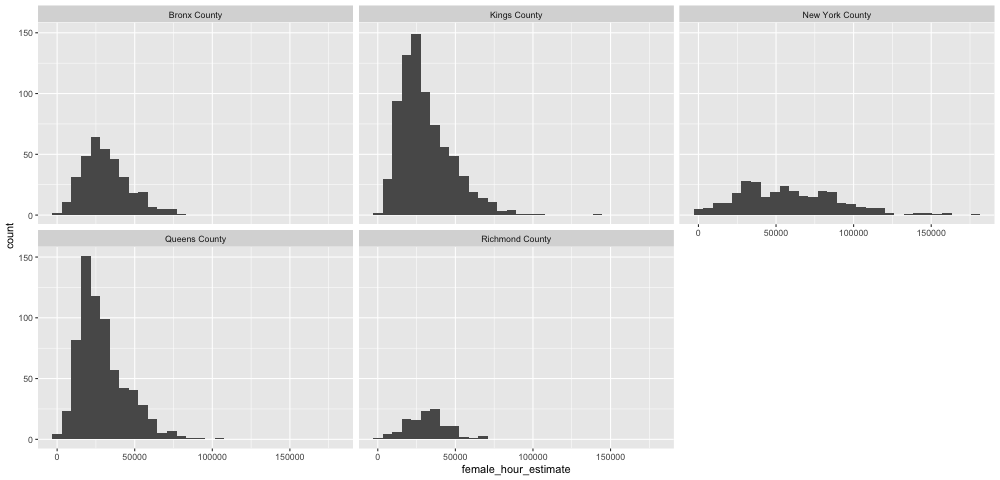

In [99]:
%%R -w 1000
# explore and understand female working hours by comapring with boroughs

ggplot(nyc_census_data) + 
    aes(x=female_hour_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 

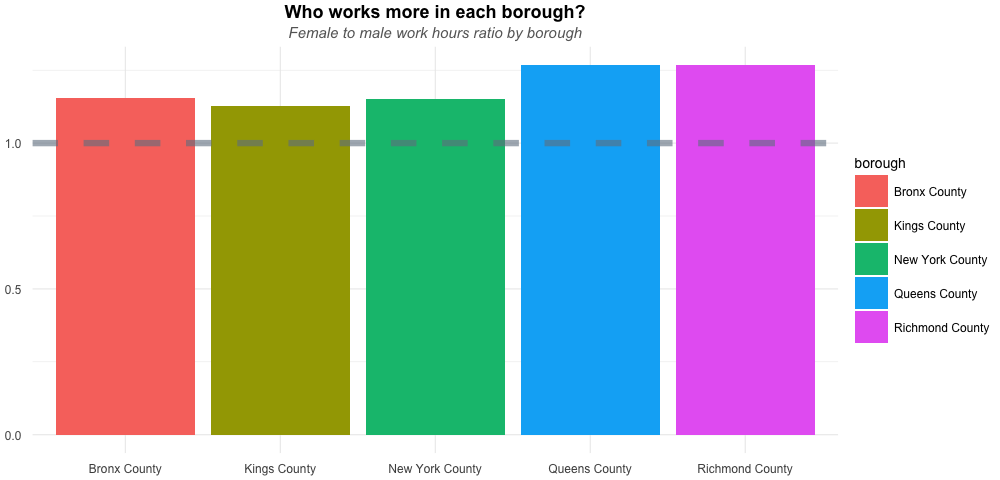

In [133]:
%%R -w 1000
# explore if female works more or male works more in each borough
nyc_borough_summary <- nyc_census_data %>%
  group_by(borough) %>%
  summarise(
    avg_female_hours = mean(female_hour_estimate, na.rm = TRUE),
    avg_male_hours = mean(male_hour_estimate, na.rm = TRUE),
    female_to_male_ratio = mean(male_hour_estimate / female_hour_estimate, na.rm = TRUE)
  )
# I used the ratio Female Work Hours / Male Work Hours to see; if raio >1, then female works more 
ggplot(nyc_borough_summary, aes(x = borough, y = female_to_male_ratio, fill = borough)) +
  geom_col() +
    geom_hline(yintercept = 1, linetype = "dashed", color = "slategrey", size = 3, alpha=0.6) + 
  labs(title = "Who works more in each borough?",
       subtitle = "Female to male work hours ratio by borough",
       x = "Borough",
       y = "Female / Male Work Hours Ratio") +
  theme_minimal() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 15, face = "italic", color = "gray40"),
        plot.caption = element_text(hjust = 1, size = 12, face = "italic", color = "black"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key.size = unit(1.2, "cm"),  
        axis.title.x = element_blank(),  
        axis.title.y = element_blank(),
        plot.margin = margin(5, 5, 5, 5),
        axis.ticks.length = unit(0.3, "cm") 
    ) +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 15, face = "italic", color = "gray40"),
        plot.caption = element_text(hjust = 1, size = 12, face = "italic", color = "black"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key.size = unit(1.2, "cm"),  
        axis.title.x = element_blank(),  
        axis.title.y = element_blank(),
        plot.margin = margin(5, 5, 5, 5),
        axis.ticks.length = unit(0.3, "cm") 
    ) 


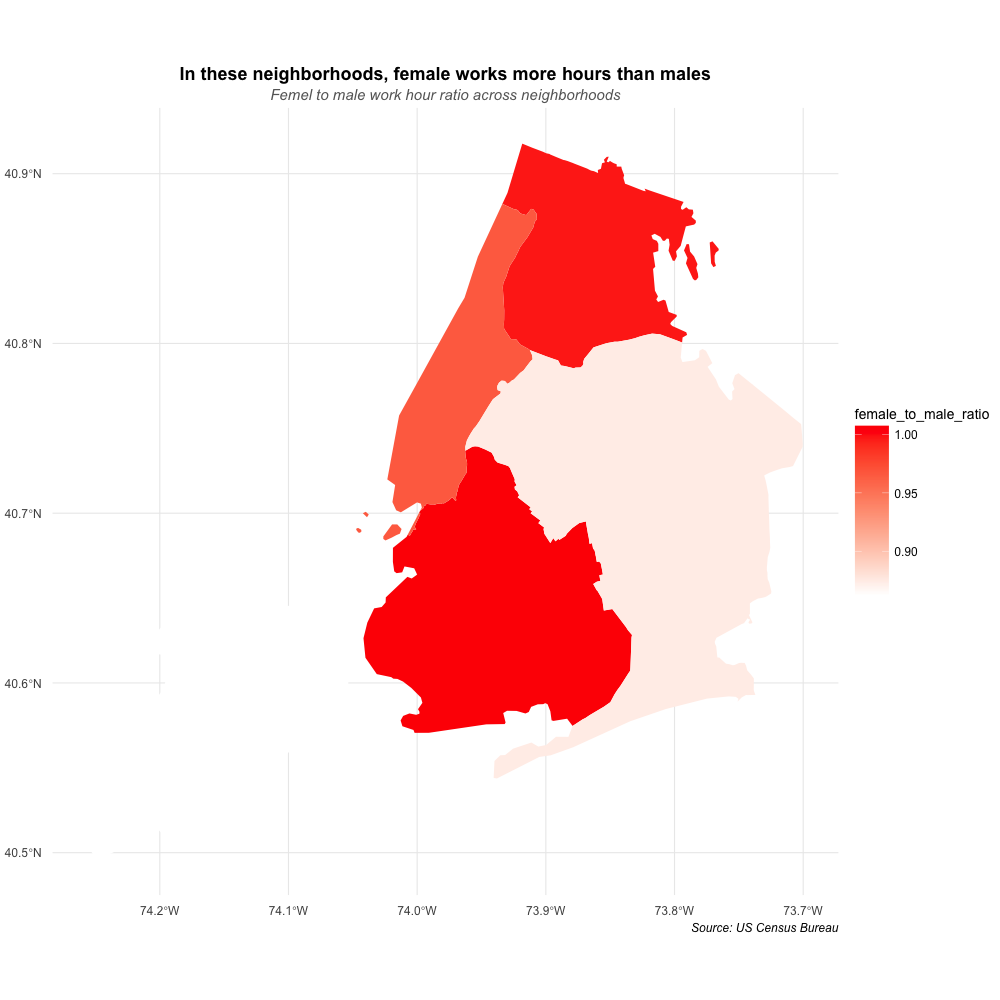

In [135]:
%%R -w 1000 -h 1000
# mapping 
nyc_borough_summary <- nyc_census_data %>%
  group_by(borough) %>%
  summarise(
    avg_female_hours = mean(female_hour_estimate, na.rm = TRUE),
    avg_male_hours = mean(male_hour_estimate, na.rm = TRUE),
    female_to_male_ratio = mean(female_hour_estimate / male_hour_estimate, na.rm = TRUE)
  )

nyc_borough_summary %>%
  ggplot(aes(fill = female_to_male_ratio)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "In these neighborhoods, female works more hours than males",
    subtitle = "Femel to male work hour ratio across neighborhoods",
    caption = "Source: US Census Bureau"
  ) +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 15, face = "italic", color = "gray40"),
        plot.caption = element_text(hjust = 1, size = 12, face = "italic", color = "black"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key.size = unit(1.2, "cm"), 
        plot.margin = margin(5, 5, 5, 5),
        axis.ticks.length = unit(0.3, "cm") 
    ) 


### Visualize the difference between male and female working hours

In [109]:
%%R -w 1000

nyc_long <- nyc_census_data %>%
  select(borough, male_hour_estimate, female_hour_estimate) %>%
  pivot_longer(cols = c(male_hour_estimate, female_hour_estimate),
               names_to = "gender",
               values_to = "work_hours") %>%
  mutate(
    work_hours = ifelse(gender == "male_hour_estimate", -work_hours, work_hours),  # Invert male hours
    gender = recode(gender, "male_hour_estimate" = "Male", "female_hour_estimate" = "Female")
  )

# Check the structure
head(nyc_long)



Simple feature collection with 6 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -73.90606 ymin: 40.82439 xmax: -73.84726 ymax: 40.85594
Geodetic CRS:  NAD83
# A tibble: 6 × 4
  borough                                             geometry gender work_hours
  <chr>                                     <MULTIPOLYGON [°]> <chr>       <dbl>
1 Bronx County (((-73.906 40.84939, -73.90562 40.84992, -73.9… Male       -32571
2 Bronx County (((-73.906 40.84939, -73.90562 40.84992, -73.9… Female      37938
3 Bronx County (((-73.90508 40.82711, -73.90385 40.82819, -73… Male       -12188
4 Bronx County (((-73.90508 40.82711, -73.90385 40.82819, -73… Female      21241
5 Bronx County (((-73.85773 40.83356, -73.85465 40.83389, -73… Male       -48599
6 Bronx County (((-73.85773 40.83356, -73.85465 40.83389, -73… Female      45666


Warning message:
Removed 215 rows containing missing values or values outside the scale range
(`geom_bar()`). 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 215 rows containing missing values or values outside the scale range
(`geom_bar()`). 



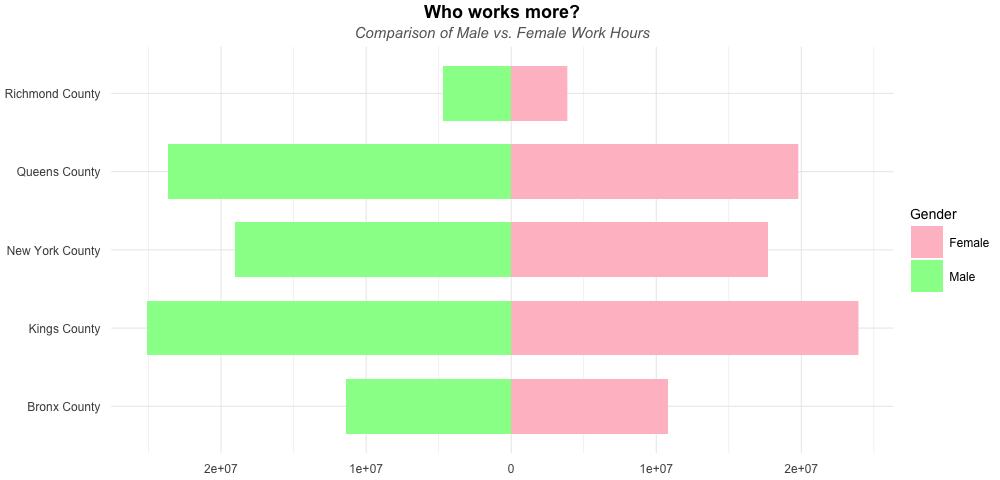

In [118]:
%%R -w 1000

# inspired by https://walker-data.com/tidycensus/articles/other-datasets.html

ggplot(nyc_long, aes(x = work_hours, y = borough, fill = gender)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_x_continuous(labels = abs, limits = c(-max(nyc_long$work_hours), max(nyc_long$work_hours))) +
  scale_fill_manual(values = c("Male" = "#98FF98", "Female" = "pink")) +
  labs(
    title = "Who works more?",
    subtitle = "Comparison of Male vs. Female Work Hours",
    x = "Total Work Hours (Negative for Male, Positive for Female)",
    y = "Borough",
    fill = "Gender"
  ) +
  theme_minimal() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 15, face = "italic", color = "gray40"),
        plot.caption = element_text(hjust = 1, size = 12, face = "italic", color = "black"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key.size = unit(1.2, "cm"),  
        axis.title.x = element_blank(),  
        axis.title.y = element_blank(),
        plot.margin = margin(5, 5, 5, 5),
        axis.ticks.length = unit(0.3, "cm") 
    ) 
